In [86]:
import numpy as np
import pickle
import cv2
import os
import cv2 as cv
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# CNN MODEL

In [48]:
EPOCHS=10
INIT_LR=1e-05
BS=32
default_image_size=tuple((100,100))
image_size=0


directory_root=r"F:\DL projects\Data sets\Tomato leaf Data set\New Plant Diseases Dataset(Augmented)"

In [49]:
#converting images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [50]:
 #labelling images based on their category
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing train ...
[INFO] Processing valid ...
[INFO] Processing Tomato bacterial spot ...
[INFO] Processing Tomato early blight ...
[INFO] Processing Tomato healthy ...
[INFO] Processing Tomato late blight ...
[INFO] Processing Tomato leaf mold ...
[INFO] Processing Tomato septoria leaf spot ...
[INFO] Processing Tomato spider mites Two spotted spider mite ...
[INFO] Processing Tomato target spot ...
[INFO] Processing Tomato tomato mosaic virus ...
[INFO] Processing Tomato tomato yellow leaf curl virus ...
[INFO] Processing Tomato bacterial spot ...
[INFO] Processing Tomato early blight ...
[INFO] Processing Tomato healthy ...
[INFO] Processing Tomato late blight ...
[INFO] Processing Tomato leaf mold ...
[INFO] Processing Tomato septoria leaf spot ...
[INFO] Processing Tomato spider mites Two spotted spider mite ...
[INFO] Processing Tomato target spot ...
[INFO] Processing Tomato tomato mosaic virus ...
[INFO] Processing Tomato tomato yellow leaf c

In [51]:
#one hot encoding
label_binarizer = LabelBinarizer() 
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [53]:
#scaling
image_list = np.array(image_list, dtype=np.float16)/255.0 

In [54]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [55]:
#Data augmentation
dataaug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [56]:
#model structure
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same",input_shape=(100,100,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_26 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 64)        18496     
_________________________________________________________________
activation_27 (Activation)   (None, 33, 33, 64)       

In [58]:
#model compile
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [66]:
#fit train and test data in model
hist1 = model.fit_generator(
    dataaug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=15, verbose=1
    )

Epoch 1/15
100/100 [==============================] - 87s 875ms/step - loss: 0.1093 - accuracy: 0.7944 - val_loss: 0.5269 - val_accuracy: 0.4975
Epoch 2/15
100/100 [==============================] - 90s 897ms/step - loss: 0.1101 - accuracy: 0.7916 - val_loss: 0.5185 - val_accuracy: 0.4938
Epoch 3/15
100/100 [==============================] - 89s 890ms/step - loss: 0.1084 - accuracy: 0.7875 - val_loss: 0.4214 - val_accuracy: 0.5325
Epoch 4/15
100/100 [==============================] - 88s 875ms/step - loss: 0.1100 - accuracy: 0.7884 - val_loss: 0.4942 - val_accuracy: 0.4988
Epoch 5/15
100/100 [==============================] - 86s 861ms/step - loss: 0.1046 - accuracy: 0.7919 - val_loss: 0.4613 - val_accuracy: 0.5113
Epoch 6/15
100/100 [==============================] - 90s 897ms/step - loss: 0.1052 - accuracy: 0.7950 - val_loss: 0.5057 - val_accuracy: 0.5013
Epoch 7/15
100/100 [==============================] - 90s 901ms/step - loss: 0.0990 - accuracy: 0.8016 - val_loss: 0.5349 - val_ac

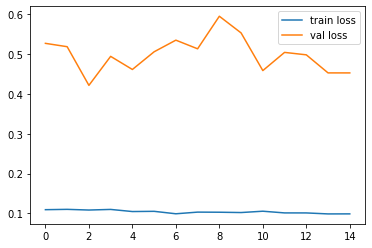

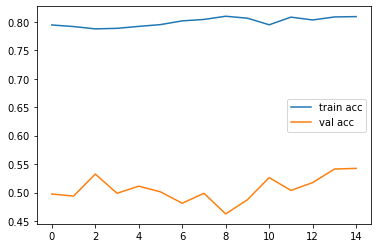

<Figure size 432x288 with 0 Axes>

In [67]:
#plots of loss and accuracy
plt.plot(hist1.history['loss'], label='train loss')
plt.plot(hist1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist1.history['accuracy'], label='train acc')
plt.plot(hist1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [68]:
model.save('MODEL1.h1')

INFO:tensorflow:Assets written to: MODEL1.h1\assets


# ALEXNET MODEL

In [23]:
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(100,100,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 25, 25, 96)        34944     
_________________________________________________________________
batch_normalization_9 (Batch (None, 25, 25, 96)        384       
_________________________________________________________________
activation_10 (Activation)   (None, 25, 25, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 256)       614656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 256)       1024      
_________________________________________________________________
activation_11 (Activation)   (None, 13, 13, 256)      

In [74]:
BS=64
train_generator=datagen.flow_from_directory(r"F:\DL projects\Data sets\Tomato leaf Data set\New Plant Diseases Dataset(Augmented)\train",
target_size=(img_size,img_size),
batch_size=BS,
class_mode='categorical',
shuffle=True)


validation_generator=datagen.flow_from_directory( r"F:\DL projects\Data sets\Tomato leaf Data set\New Plant Diseases Dataset(Augmented)\valid",
target_size=(img_size,img_size),
batch_size=BS,
class_mode='categorical',
shuffle=True)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
AlexNet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [16]:
ephocs=5
steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps
hist2=AlexNet.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=ephocs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps)

Epoch 1/12
286/286 [==============================] - 586s 2s/step - loss: 1.1474 - accuracy: 0.6844 - val_loss: 0.9340 - val_accuracy: 0.7522
Epoch 2/12
286/286 [==============================] - 592s 2s/step - loss: 1.0599 - accuracy: 0.7229 - val_loss: 0.8474 - val_accuracy: 0.7978
Epoch 3/12
286/286 [==============================] - 585s 2s/step - loss: 0.9894 - accuracy: 0.7502 - val_loss: 0.8179 - val_accuracy: 0.8055
Epoch 4/12
286/286 [==============================] - 589s 2s/step - loss: 0.9358 - accuracy: 0.7741 - val_loss: 0.7426 - val_accuracy: 0.8360
Epoch 5/12
286/286 [==============================] - 577s 2s/step - loss: 0.8828 - accuracy: 0.7994 - val_loss: 0.7049 - val_accuracy: 0.8457
Epoch 6/12
286/286 [==============================] - 585s 2s/step - loss: 0.8455 - accuracy: 0.8139 - val_loss: 0.7176 - val_accuracy: 0.8290
Epoch 7/12
286/286 [==============================] - 582s 2s/step - loss: 0.8129 - accuracy: 0.8224 - val_loss: 0.6158 - val_accuracy: 0.8653

In [17]:
AlexNet.save('MODEL2.h1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MODEL2.h1\assets


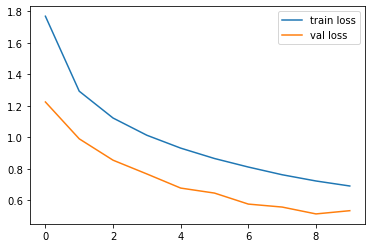

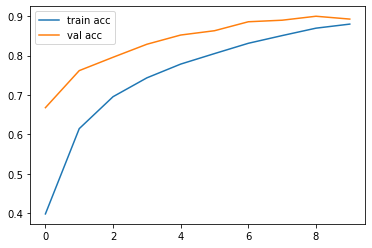

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(hist2.history['loss'], label='train loss')
plt.plot(hist2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist2.history['accuracy'], label='train acc')
plt.plot(hist2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [75]:
train=r"F:\DL projects\Data sets\Tomato leaf Data set\New Plant Diseases Dataset(Augmented)\train"
valid=r"F:\DL projects\Data sets\Tomato leaf Data set\New Plant Diseases Dataset(Augmented)\valid"
CATEGORIES=['Tomato bacterial spot', 'Tomato early blight', 'Tomato healthy', 'Tomato late blight', 'Tomato leaf mold', 'Tomato septoria leaf spot', 'Tomato spider mites two spotted spider mite', 'Tomato target spot', 'Tomato tomato mosaic virus', 'Tomato tomato yellow leaf curl virus']

In [70]:
#checking predictions
from tensorflow.keras.models import load_model
model1=load_model('MODEL1.h1')
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import cv2
test_img=image.load_img(r"F:\DL projects\Data sets\Tomato leaf Data set\New Plant Diseases Dataset(Augmented)\train\Tomato tomato mosaic virus\i (3).JPG",target_size=(100,100))
test_img=image.img_to_array(test_img)
test_img=np.expand_dims(test_img,axis=0)
result1=model1.predict(test_img)
pred1=result1.argmax()


CATEGORIES[pred1]

'Tomato tomato mosaic virus'

# LENET MODEL

In [4]:
LeNet=Sequential()

LeNet.add(Conv2D(6, kernel_size=(3,3), input_shape=(100,100,3), activation='relu'))
LeNet.add(AveragePooling2D())

LeNet.add(Conv2D(16, kernel_size=(3,3),activation='relu'))
LeNet.add(AveragePooling2D())

#LeNet.add(Conv2D(80, kernel_size=(5,5), activation='relu', padding='valid'))
#LeNet.add(MaxPooling2D(pool_size=(2,2)))
#LeNet.add(Dropout(0.2))

LeNet.add(Flatten())
LeNet.add(Dense(120,activation='relu'))
LeNet.add(Dense(84,activation='relu'))

LeNet.add(Dense(10))
LeNet.add(Activation("softmax"))

In [5]:
LeNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 6)         168       
_________________________________________________________________
average_pooling2d (AveragePo (None, 49, 49, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 23, 23, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8464)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               1015800   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [7]:
LeNet.compile(loss="categorical_crossentropy",optimizer="Adam", metrics=["accuracy"])

In [8]:
#data-augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False, 
        zca_whitening=False,
        rotation_range=20, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True, 
        vertical_flip=False)

In [19]:
epochs=5
steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps
hist3=LeNet.fit(datagen.flow(train_generator),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps)

Epoch 1/5
286/286 [==============================] - 439s 2s/step - loss: 0.3839 - accuracy: 0.8666 - val_loss: 0.3543 - val_accuracy: 0.8772
Epoch 2/5
286/286 [==============================] - 201s 703ms/step - loss: 0.3951 - accuracy: 0.8664 - val_loss: 0.3867 - val_accuracy: 0.8699
Epoch 3/5
286/286 [==============================] - 172s 600ms/step - loss: 0.3566 - accuracy: 0.8788 - val_loss: 0.3771 - val_accuracy: 0.8675
Epoch 4/5
286/286 [==============================] - 140s 491ms/step - loss: 0.3524 - accuracy: 0.8762 - val_loss: 0.3047 - val_accuracy: 0.8893
Epoch 5/5
286/286 [==============================] - 149s 520ms/step - loss: 0.3445 - accuracy: 0.8818 - val_loss: 0.3404 - val_accuracy: 0.8889


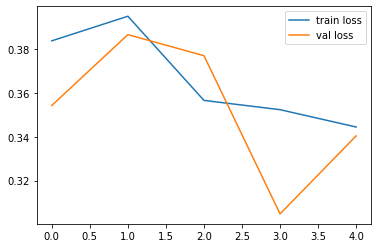

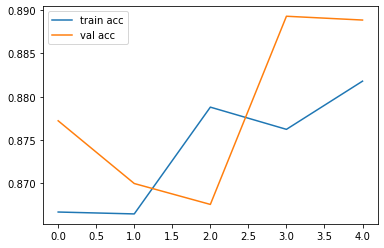

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(hist3.history['loss'], label='train loss')
plt.plot(hist3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist3.history['accuracy'], label='train acc')
plt.plot(hist3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [27]:
LeNet.save('MODEL3.h1')

INFO:tensorflow:Assets written to: MODEL3.h1\assets


In [29]:
from tensorflow.keras.models import load_model

In [71]:
count=0

In [72]:
#model ensembling
model1=load_model('MODEL1.h1')
model2=load_model('MODEL2.h1')
model3=load_model('MODEL3.h1')
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(valid,category)
        for img_file in os.listdir(path):
            img=cv.imread(os.path.join(path,img_file),1)
            img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
            img=cv.resize(img,(100,100))  
            if img is not None:
               test_img=image.img_to_array(img)
               test_img=np.expand_dims(test_img,axis=0)
               result1=model1.predict(test_img)
               a=result1.argmax()
               result2=model2.predict(test_img)
               b=result2.argmax()
               result3=model3.predict(test_img)
               c=result3.argmax()
               if(a==b or b==c or c==a or a==b==c):#max voting
                  count=count+1

In [77]:
#correct predictions out 4585 test data set
count

4209

In [28]:
#for i in range(len(y_test)):
    #if(y_test[i]==y_pred[i]):
        #count1=count1+1;

In [84]:
ensemble_acc= count*100/4585

In [85]:
ensemble_acc

91.79934569247547